# Bottleneck Distance Demonstration

In this notebook, we explore more persistence diagrams and compute distances between them using bottleneck distance. We will also use bottleneck distance between persistence diagrams to do a simple shape classification experiment.

In [2]:
# Import standard packages for TDA
from ripser import ripser
from ripser import Rips
import persim
from persim import plot_diagrams 
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import datasets

# Import packages for loading .mat files
import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

First we need to load the data set. The data consists of a large number of densely sampled plane curves representing various objects (bones, dogs, cars, etc.). The file is a .mat file, which we read into Python with the following commands.

In [3]:
data_dir = os.getcwd() # Get the current working directory name.
mat_fname = pjoin(data_dir, 'planarShapes.mat') 
# Add the file name to the current working directory.

mat_contents = sio.loadmat(mat_fname) # Read the file

Let's take a look at what is contained in the file.

In [4]:
mat_contents

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Apr 14 11:14:24 2018',
 '__version__': '1.0',
 'planarShapes': array([[[357.34453529, 357.44718391, 357.37970648, ...,  83.38883583,
          159.45819277,  78.49098244],
         [347.75040292, 347.25818387, 347.57146265, ...,  79.33298424,
          153.64433782,  77.51641748],
         [335.65167015, 334.66219996, 335.31828711, ...,  75.50067507,
          145.06346946,  75.98649446],
         ...,
         [382.34195746, 383.10101704, 382.58259628, ..., 105.00318471,
          177.03582561,  92.11431972],
         [368.61866608, 369.59966211, 369.02935511, ...,  93.29463409,
          169.58421811,  84.79921417],
         [358.82786411, 359.34800766, 359.06800864, ...,  85.56932952,
          162.53121921,  79.92520447]],
 
        [[  1.45686688,   1.48050543,   1.4549982 , ...,  38.82553081,
           17.85770528,  88.12826329],
         [  8.85738844,   9.36434503,   9.06410148, ...,  45

Looks like we need to separate the actual data from the metadata. The types of data in the file are listed under several "keys". 

In [5]:
mat_contents.keys()

['__version__', '__header__', 'planarShapes', '__globals__']

The plane curves we are after are under the 'planarShapes' key. Let's extract that from the mat file.

In [6]:
planarShapes = mat_contents['planarShapes']
planarShapes.shape

(2, 100, 1300)

The second command above shows that planarShapes is a 2x100x1300 array. Exploring more, we would find that there are 1300 separate shapes, separated into 20 copies of similar shapes (so 65 classes of similar shapes). Each of the 1300 shapes is a pointcloud in $\mathbb{R}^2$ consisting of 100 points. Let's plot a couple of the shapes below.

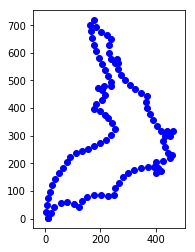

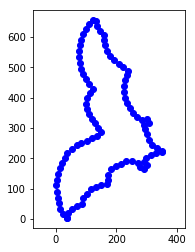

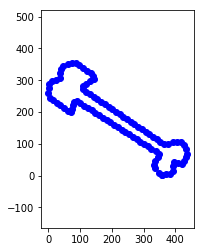

In [7]:
shape1 = planarShapes[:,:,125] # Pick some shapes.
shape2 = planarShapes[:,:,127]
shape3 = planarShapes[:,:,1]

# The commands below plot the shape that we picked.
fig1 = pl.figure()
ax1 = fig1.add_subplot(121)
ax1.plot(shape1[0, :], shape1[1, :], 'ob');
ax1.axis('equal');
fig2 = pl.figure()
ax2 = fig2.add_subplot(121)
ax2.plot(shape2[0, :], shape2[1, :], 'ob');
ax2.axis('equal');
fig3 = pl.figure()
ax3 = fig3.add_subplot(121)
ax3.plot(shape3[0, :], shape3[1, :], 'ob');
ax3.axis('equal');

Let's compute persistence diagrams for these examples, then look at bottleneck distances between them. Note that ripser prefers the pointclouds to be transposed. I.e., shape1 is given as a 2x100 array, but ripser wants to see a 100x2 array.

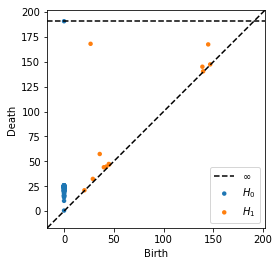

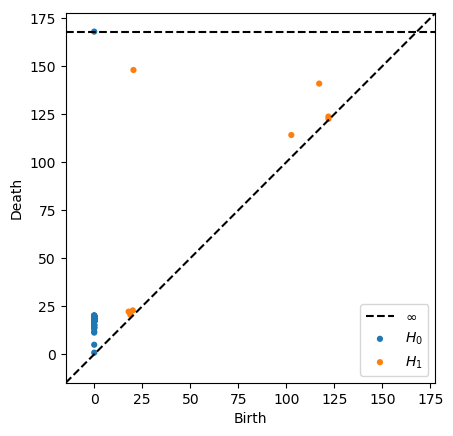

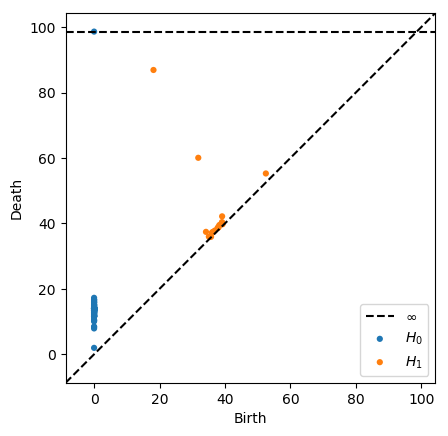

In [8]:
shape1Dgm = ripser(np.transpose(shape1))['dgms'] 
shape2Dgm = ripser(np.transpose(shape2))['dgms']
shape3Dgm = ripser(np.transpose(shape3))['dgms']

fig1 = pl.figure()
plot_diagrams(shape1Dgm)
fig2 = pl.figure()
plot_diagrams(shape2Dgm)
fig3 = pl.figure()
plot_diagrams(shape3Dgm)

The "persim" package includes several distance metrics between persistence diagrams, including the bottleneck distance that we have defined in class. Let's compute bottleneck distances between our shape examples. There is an option to not only compute the distance, but to record the optimal matching which produces it. In the first example, we compute the bottleneck distance between the degree 1 persistence diagrams for shape1 and shape2.

In [9]:
distance_bottleneck, (matching, D) = persim.bottleneck(shape1Dgm[1], shape2Dgm[1], matching=True)
print(distance_bottleneck)

20.066848754882812


We can then plot the persistence diagrams on the same axes and display the optimal matching. The green line segment indicates matched points. All other points are matched with the diagonal.

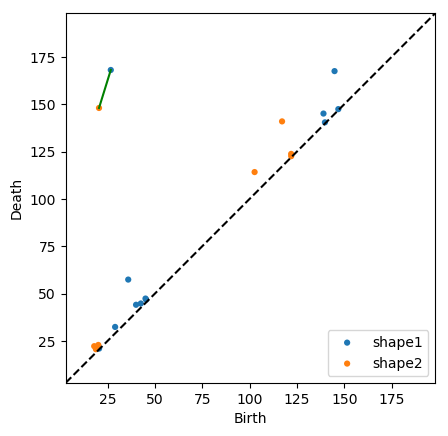

In [10]:
persim.plot.bottleneck_matching(shape1Dgm[1], shape2Dgm[1], matching, D, labels=['shape1', 'shape2'])

Let's also compute the distance between shape2 and shape3.

In [11]:
distance_bottleneck, (matching, D) = persim.bottleneck(shape2Dgm[1], shape3Dgm[1], matching=True)
print(distance_bottleneck)

61.09130859375


Note that shape1 and shape2 came from the same class of shapes, whereas shape 3 comes from a different class. This is reflected in the fact that the distance here is much larger than the distance between shape1 and shape2. When we plot the matching, we see that points which are much farther apart must get matched together. 

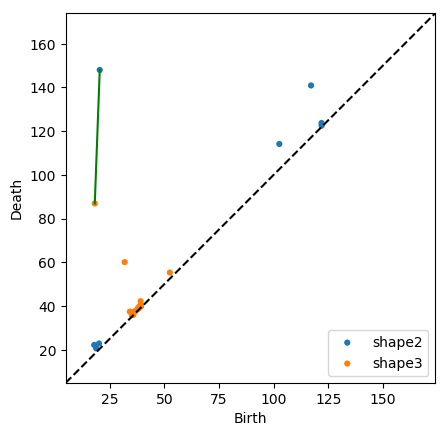

In [12]:
persim.plot.bottleneck_matching(shape2Dgm[1], shape3Dgm[1], matching, D, labels=['shape2', 'shape3'])

So bottleneck distance seems to pick up on differences in the shapes. This suggests that we could try a simple classification experiment.

## Classification Experiment
For our experiment, we will extract some small number of shapes from the total collection. We would also prefer to have a list of 2x100 arrays, rather than a big 2x100x1300 arrays. Finally, ripser uses a 100x2 format, so we should transpose all of our arrays.

In [13]:
shape_classes = [0,100,200,300,400,500] # Pick indices of shape classes to sample.
num_shapes = 5 # Pick number of examples to take from each shape class

# List all indices of the shape samples for the experiment.
samples =[]
for j in range(len(shape_classes)):
    samples = samples+range(shape_classes[j],shape_classes[j]+num_shapes)

# We now pick out the shapes with indices in 'samples' and preprocess.
num_samp = len(samples)
shapeSamples = range(num_samp)

for j in range(num_samp):
    shape = planarShapes[:,:,samples[j]]
    shapeSamples[j] = np.transpose(shape)

Let's take a look at shapes from each of the shape classes.

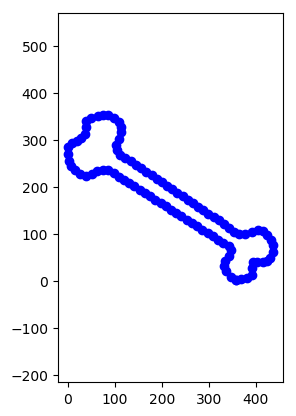

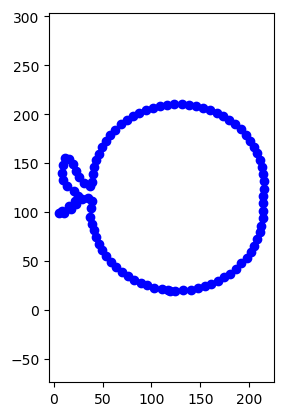

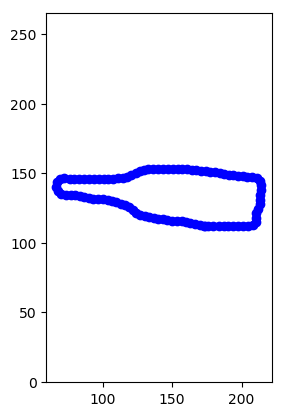

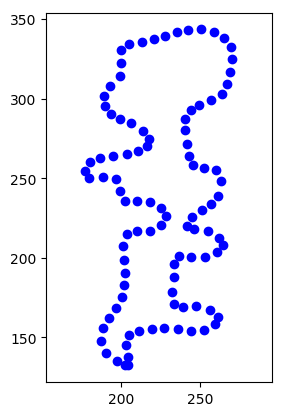

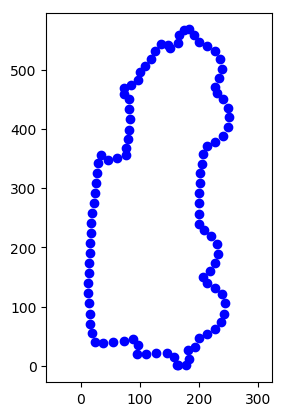

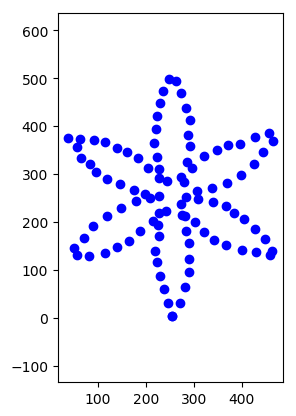

In [14]:
for j in range(len(shape_classes)):
    shape_example = planarShapes[:,:,shape_classes[j]]
    figName = 'fig'+str(j)
    axName = 'ax'+str(j)

    figName = pl.figure()
    axName = figName.add_subplot(121)
    axName.plot(shape_example[0, :], shape_example[1, :], 'ob');
    axName.axis('equal');

Let's also look at the samples within a given class of shapes.

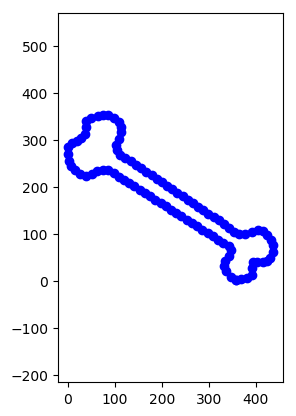

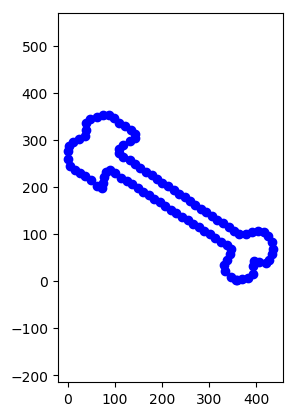

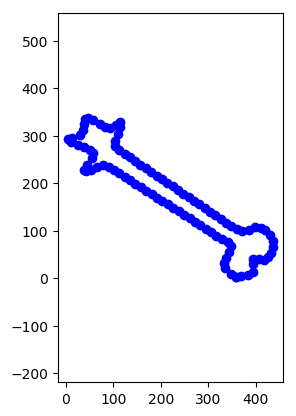

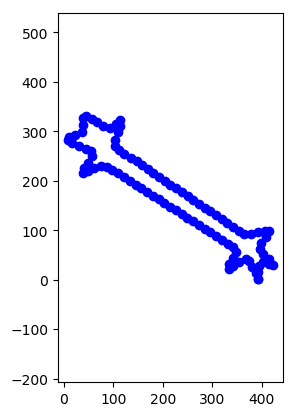

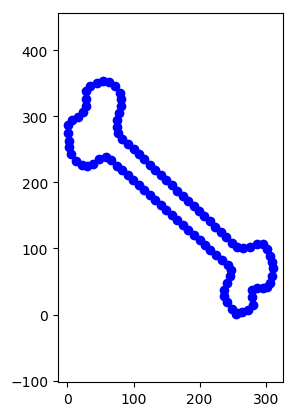

In [15]:
for j in range(num_shapes):
    shape_example = planarShapes[:,:,shape_classes[0]+j]
    figName = 'fig'+str(j)
    axName = 'ax'+str(j)

    figName = pl.figure()
    axName = figName.add_subplot(121)
    axName.plot(shape_example[0, :], shape_example[1, :], 'ob');
    axName.axis('equal');

Next we compute persistence diagrams for each of the shapes in our sampled collection. We are using the standard options for ripser, which will compute degree-0 and degree-1 persistence diagrams.

In [16]:
shapeSamplesDgms = range(0,num_samp)

for j in range(len(samples)):
    shapeSamplesDgms[j] = ripser(shapeSamples[j])['dgms']

We can now compute bottleneck distances between all pairs of persistence diagrams. We computed persistence diagrams for degree-0 and degree-1 persistent homology in the previous cell, so we could compute bottleneck distances in each degree.

It takes quite a while to run the degree-0 computation. It is commented out in the cell below because I don't want to run it in class. Feel free to uncomment and try it yourself.

In the cell below that, we compute the distance matrix for the degree-1 persistence diagrams. Note that, if there are N total shape samples, then this distance matrix should be an NxN symmetric matrix. The $(i,j)$-entry is the bottleneck distance between the persistence diagram of shape $i$ and shape $j$. We are really thinking of each shape as a point in a metric space!

In [ ]:
#distMatDeg0 = np.zeros([num_samp,num_samp])

#for j in range(num_samp):
#    for k in range(j+1,num_samp):
#        distMatDeg0[j,k] = persim.bottleneck(shapeSamplesDgms[j][0], shapeSamplesDgms[k][0])
#    print(j)

#distMatDeg0 = distMatDeg0 + np.transpose(distMatDeg0)

In [17]:
distMatDeg1 = np.zeros([num_samp,num_samp])

for j in range(num_samp):
    for k in range(j+1,num_samp):
        distMatDeg1[j,k] = persim.bottleneck(shapeSamplesDgms[j][1], shapeSamplesDgms[k][1])

distMatDeg1 = distMatDeg1 + np.transpose(distMatDeg1)

To understand the structure of our metric space, we can take a look at the distance matrix. Once the matrix gets large enough, it becomes uninformative to look at the actual numbers. Typically it is easier to look at a color-coded picture of the distance matrix, which we do below.

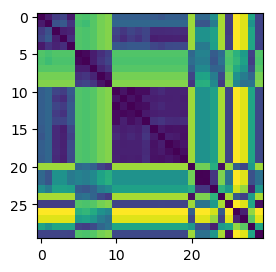

In [18]:
pl.figure()
pl.subplot(121)
pl.imshow(distMatDeg1)
pl.show()

To understand the structure of our metric space more fully, we can try dimension reduction and visualization techniques. Here we will use an algorithm called 'multidimensional scaling'. This will take our \emph{abstract} finite metric space (which doesn't naturally live in any Euclidean space), and find the most faithful representation as a finite subset of $\mathbb{R}^n$, for whichever $n$ we choose (typically $n=2$ or $3$ so that we can visualize the result). Here 'most faithful' means that the resulting Euclidean set should have a distance matrix which is as close as possible to the one picture above.

First we will use multidimensional scaling to represent our abstract metric space as a subset of the plane.

In [19]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMatDeg1)
coords = results.embedding_

Now we can plot the MDS representation of our metric space. The points are color-coded by shape class. We see that there is some reasonably nice clustering of the points---points from the same shape class tend to lie closer together!

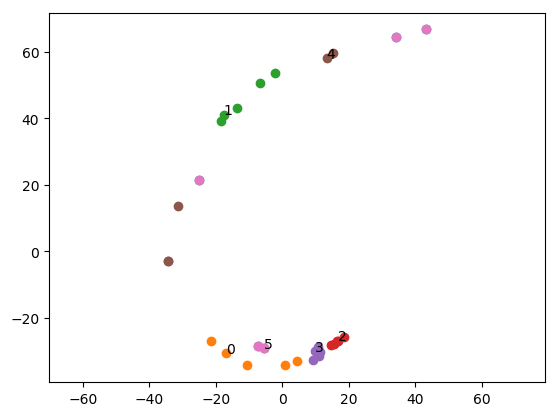

In [20]:
fig1 = pl.figure()
ax1 = fig1.add_subplot(111)

for j in range(len(shape_classes)+1):
    R = range((j-1)*num_shapes,j*num_shapes)
    ax1.plot(coords[R, 0], coords[R, 1],'o');
    ax1.axis('equal');

# Add labels to indicate which color corresponds to each shape class
for i in range(len(shape_classes)):
    ax1.annotate(str(i), (coords[i*num_shapes,0], coords[i*num_shapes,1]))

We can also run MDS to represent our metric space in $\mathbb{R}^3$. To me this doesn't seem to drastically change the clustering behavior.

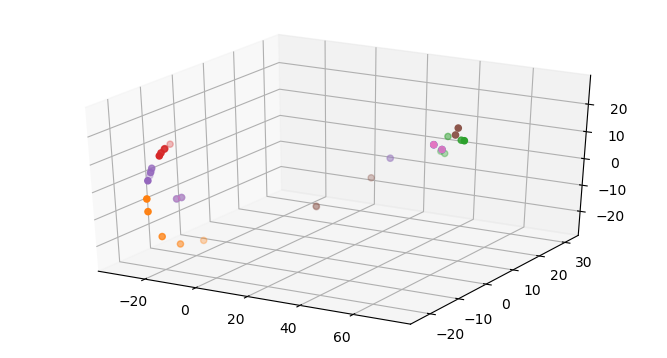

In [21]:
mds = manifold.MDS(n_components=3, dissimilarity="precomputed", random_state=6)

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMatDeg1)
coords = results.embedding_

fig = pl.figure()
ax = Axes3D(fig)

for j in range(len(shape_classes)+1):
    R = range((j-1)*num_shapes,j*num_shapes)
    ax.scatter(coords[R,0],coords[R,1],coords[R,2], marker='o');
    ax.set_aspect('equal');

Visually it appears that shape class 5 is the only one that is not realy clustered very well. Let's take a look at the shapes in that class.

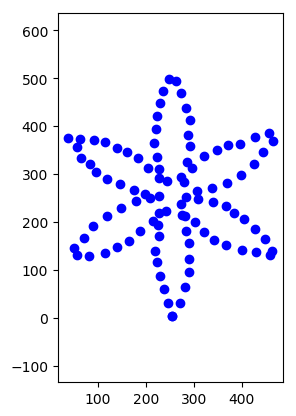

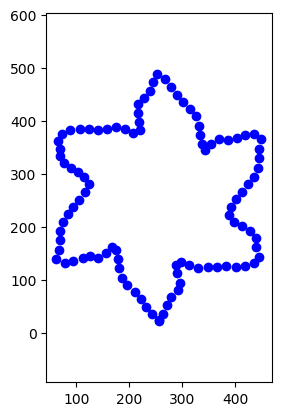

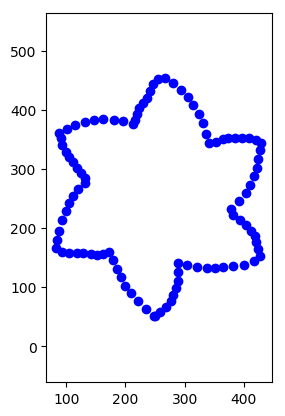

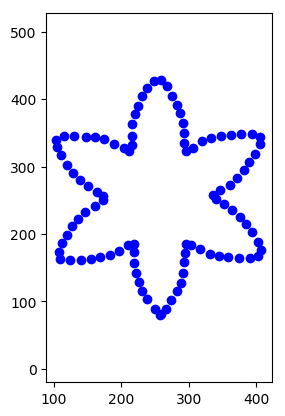

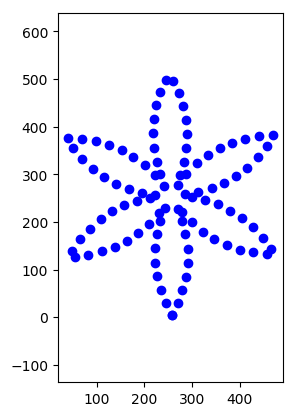

In [22]:
worst_cluster_index = 5

for j in range(num_shapes):
    shape_example = planarShapes[:,:,shape_classes[worst_cluster_index]+j]
    figName = 'fig'+str(j)
    axName = 'ax'+str(j)

    figName = pl.figure()
    axName = figName.add_subplot(121)
    axName.plot(shape_example[0, :], shape_example[1, :], 'ob');
    axName.axis('equal');

We can also look at a clustering dendrogram for the distance matrix to get more of an idea about how the points are clustered in the metric space.

In [24]:
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings("ignore")

# The linkage function was giving me a warning (but still computing) that I couldn't figure out.
# I supressed these warnings with the function above. This is not recommended in general!

linkage = hierarchy.linkage(distMatDeg1, 'single')

When we plot the dendrogram, we see that there is some distinct clustering. The shapes are roughly clustered by class, although not perfectly. We could get quanitative descriptions of the clustering behavior (e.g., by nearest neighbor classification rate).

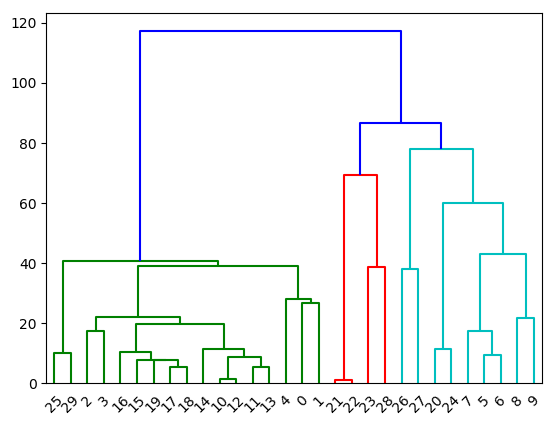

In [25]:
pl.figure()
dn = hierarchy.dendrogram(linkage)